# ChatGPT Reviews Analysis

In [ ]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# 1. Data Cleaning

Load the Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/chatgpt_reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196727 entries, 0 to 196726
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Review Id    196727 non-null  object
 1   Review       196721 non-null  object
 2   Ratings      196727 non-null  int64 
 3   Review Date  196727 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.0+ MB


Standardize Column Names

In [ ]:
print(df.head(5))

                              Review Id  \
0  6fb93778-651a-4ad1-b5ed-67dd0bd35aac   
1  81caeefd-3a28-4601-a898-72897ac906f5   
2  452af49e-1d8b-4b68-b1ac-a94c64cb1dd5   
3  372a4096-ee6a-4b94-b046-cef0b646c965   
4  b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da   

                                              Review  Ratings  \
0                                               good        5   
1                                               good        5   
2                                           nice app        5   
3                                           nice, ig        5   
4  this is a great app, the bot is so accurate to...        5   

           Review Date  
0  2024-08-23 19:30:05  
1  2024-08-23 19:28:18  
2  2024-08-23 19:22:59  
3  2024-08-23 19:20:50  
4  2024-08-23 19:20:39  


In [ ]:
# Standardize column names: convert to lowercase and replace spaces with underscores.
df.columns = df.columns.str.lower().str.replace(' ', '_')

print(df.columns)

Index(['review_id', 'review', 'ratings', 'review_date'], dtype='object')


Handle Missing Values

In [ ]:
print(df.isnull().sum())

review_id      0
review         6
ratings        0
review_date    0
dtype: int64


Show missing values in each column.

In [ ]:
df['review'] = df['review'].fillna('')

Fill missing reviews with empty string.

In [ ]:
df['review'] = df['review'].fillna('')

Convert Review_Date to Datetime.

In [ ]:
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')

Ensure Ratings is numeric and remove rows where essential data is missing.

In [ ]:
df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')

Check for missing values again

In [ ]:
print(df.isnull().sum())

review_id      0
review         0
ratings        0
review_date    0
dtype: int64


# 2. Sentiment Analysis

Perform Sentiment Analysis (Polarity and Subjectivity)

In [ ]:
# 1. Calculate Sentiment polarity.
def get_sentiment_polarity(text):
    if pd.isna(text) or text == '':
        return 0
    blob = TextBlob(str(text))
    return blob.sentiment.polarity

df['sentiment_polarity'] = df['review'].apply(get_sentiment_polarity)

In [ ]:
# 2. Assign Sentiment Category based on Polarity
def get_sentiment_category(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment_polarity'].apply(get_sentiment_category)

In [ ]:
# 3. Calculate Sentiment Subjectivity
def get_sentiment_subjectivity(text):
    if pd.isna(text) or text == '':
        return 0
    blob = TextBlob(str(text))
    return blob.sentiment.subjectivity

df['sentiment_subjectivity'] = df['review'].apply(get_sentiment_subjectivity)

Visualize Sentiment Distribution

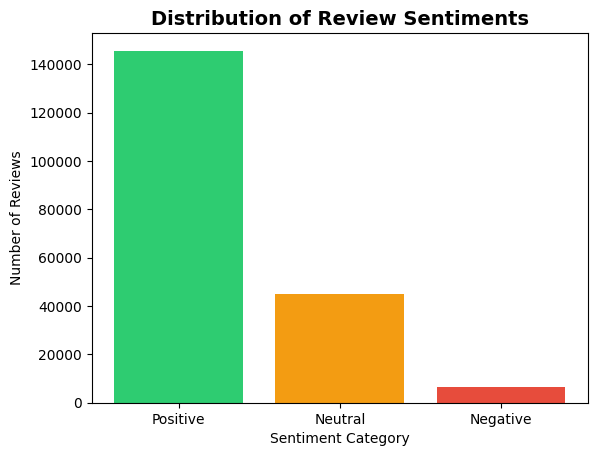

In [ ]:
sentiment_counts = df['sentiment_category'].value_counts()
colors = ['#2ecc71', '#f39c12', '#e74c3c']
plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.title('Distribution of Review Sentiments', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Reviews')
plt.show()

Plot Histogram of 'sentiment_subjectivity'

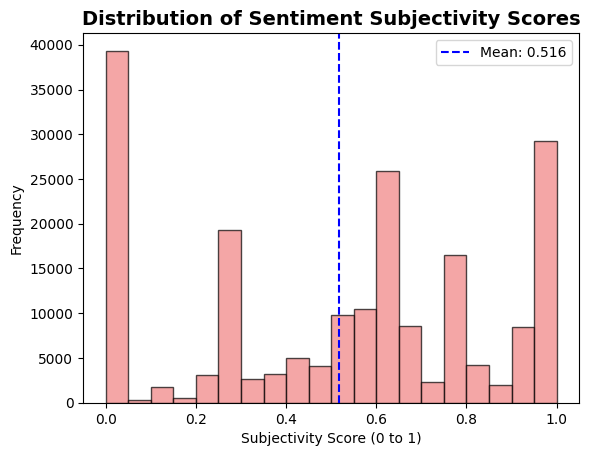

In [ ]:
# 2. Sentiment Subjectivity Distribution
plt.hist(df['sentiment_subjectivity'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
plt.axvline(df['sentiment_subjectivity'].mean(), color='blue', linestyle='--',
            label=f'Mean: {df["sentiment_subjectivity"].mean():.3f}')
plt.title('Distribution of Sentiment Subjectivity Scores', fontsize=14, fontweight='bold')
plt.xlabel('Subjectivity Score (0 to 1)')
plt.ylabel('Frequency')
plt.legend()

Rating vs Sentiment

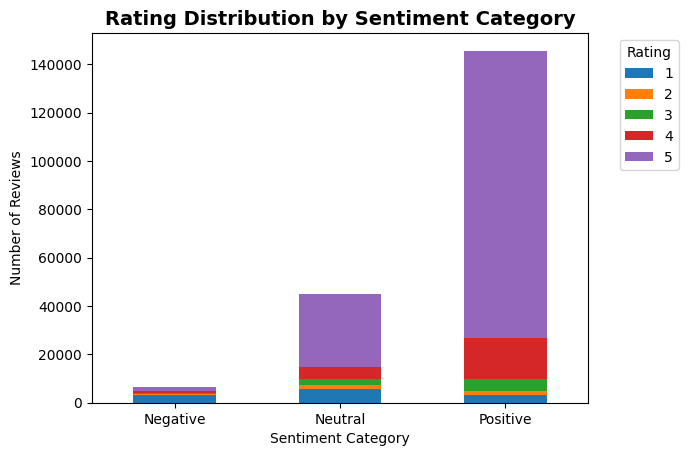

In [ ]:
# 3. Rating Distribution by Sentiment Category
sentiment_rating = df.groupby(['sentiment_category', 'ratings']).size().unstack(fill_value=0)
sentiment_rating.plot(kind='bar', stacked=True)
plt.title('Rating Distribution by Sentiment Category', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Reviews')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

# 3. Analyzing Positive Features

Filter the reviews that have a positive sentiment.

In [ ]:
positive_reviews = df[df['sentiment_category'] == 'Positive']['review']

Extract positive keywords and phrases

In [ ]:
all_text = ' '.join(positive_reviews.astype(str)).lower()

# Clean text
cleaned_text = re.sub(r'[^a-zA-Z\s]', '', all_text)
words = cleaned_text.split()

# Remove all words whose length is < 3
words = [word for word in words if len(word) > 2]

# Get phrases (bigrams and trigrams)
phrases = []
for i in range(len(words) - 1):
    if len(words[i]) > 2 and len(words[i+1]) > 2:  # Skip short words
        phrases.append(f"{words[i]} {words[i+1]}")

for i in range(len(words) - 2):
    if all(len(word) > 2 for word in words[i:i+3]):  # Skip short words
        phrases.append(f"{words[i]} {words[i+1]} {words[i+2]}")

phrase_freq = Counter(phrases)

pos_phrases = phrase_freq.most_common(10)

Visualize positive features

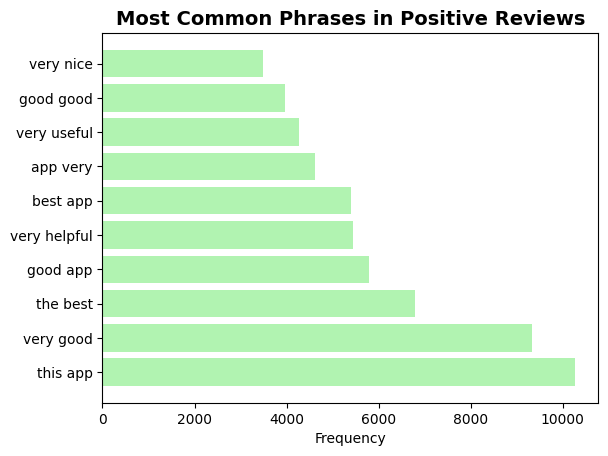

In [ ]:
phrases, phrase_counts = zip(*pos_phrases)

plt.barh(range(len(phrases)), phrase_counts, color='lightgreen', alpha=0.7)
plt.yticks(range(len(phrases)), phrases)

plt.title('Most Common Phrases in Positive Reviews', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')

plt.show()

# 4. Analyzing Negative Features

Filter negative reviews

In [ ]:
negative_reviews = df[df['sentiment_category'] == 'Negative']['review']

Extract negative keywords and phrases

In [ ]:
all_text = ' '.join(negative_reviews.astype(str)).lower()

# Clean text
cleaned_text = re.sub(r'[^a-zA-Z\s]', '', all_text)
words = cleaned_text.split()

# Remove all words whose length is < 3
words = [word for word in words if len(word) > 2]

# Get phrases (bigrams and trigrams)
phrases = []
for i in range(len(words) - 1):
    if len(words[i]) > 2 and len(words[i+1]) > 2:  # Skip short words
        phrases.append(f"{words[i]} {words[i+1]}")

for i in range(len(words) - 2):
    if all(len(word) > 2 for word in words[i:i+3]):  # Skip short words
        phrases.append(f"{words[i]} {words[i+1]} {words[i+2]}")

phrase_freq = Counter(phrases)

neg_phrases = phrase_freq.most_common(10)

Visualize negative features

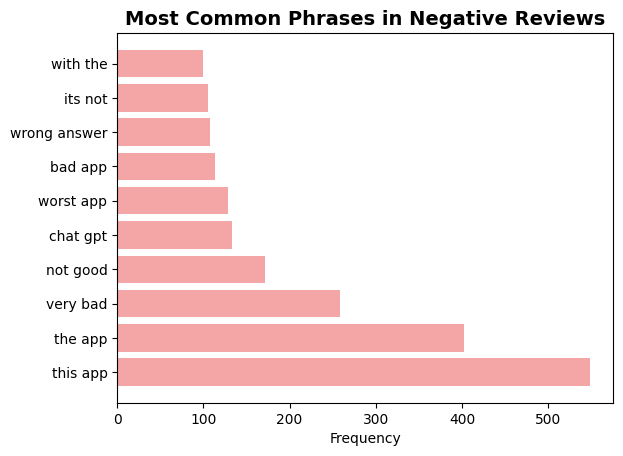

In [ ]:
phrases, phrase_counts = zip(*neg_phrases)

# Create the horizontal bar chart directly with plt
plt.barh(range(len(phrases)), phrase_counts, color='lightcoral', alpha=0.7)
plt.yticks(range(len(phrases)), phrases)

plt.title('Most Common Phrases in Negative Reviews', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')

plt.show()

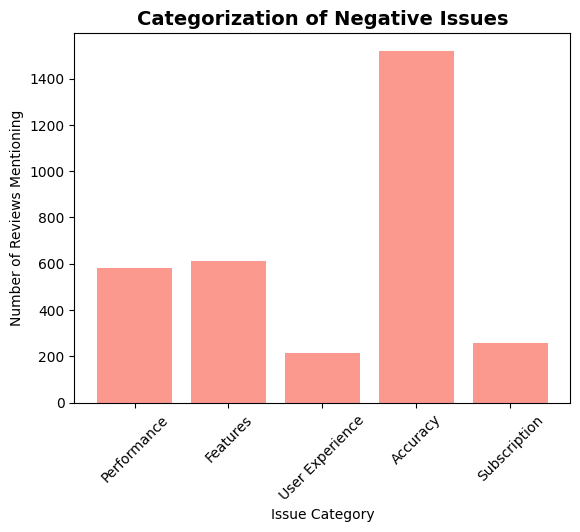

In [ ]:
issue_categories = {
    'Performance': ['slow', 'lag', 'crash', 'freeze', 'glitch', 'bug', 'error'],
    'Features': ['missing', 'lack', 'need', 'want', 'should', 'feature'],
    'User Experience': ['confusing', 'difficult', 'hard', 'complicated', 'interface'],
    'Accuracy': ['wrong', 'incorrect', 'bad', 'poor', 'inaccurate', 'mistake'],
    'Subscription': ['expensive', 'price', 'cost', 'pay', 'subscription', 'money']
}

category_counts = {}
for category, keywords in issue_categories.items():
    count = 0
    for review in negative_reviews:
        if any(keyword in str(review).lower() for keyword in keywords):
            count += 1
    category_counts[category] = count

categories = list(category_counts.keys())
counts = list(category_counts.values())

plt.bar(categories, counts, color='salmon', alpha=0.8)
plt.title('Categorization of Negative Issues', fontsize=14, fontweight='bold')
plt.xlabel('Issue Category')
plt.ylabel('Number of Reviews Mentioning')
plt.xticks(rotation=45)

plt.show()

## 5. Analyzing Neutral Features

Filter neutral reviews

In [ ]:
neutral_reviews = df[df['sentiment_category'] == 'Neutral']

Checking if the reviews are truly neutral or request some feature

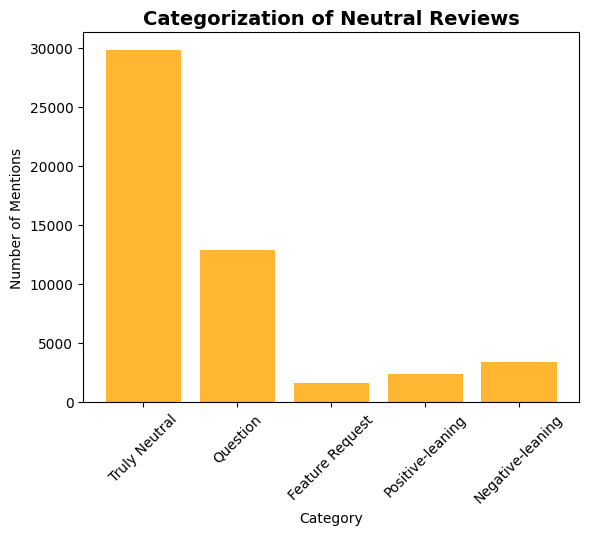

In [ ]:
neutral_texts = neutral_reviews['review']

keyword_map = {
    'Feature Request': ['add', 'include', 'feature', 'option', 'setting', 'would like', 'wish', 'hope'],
    'Question': ['how', 'what', 'why', 'when', 'where', 'can', 'does', 'is', '?'],
    'Positive-leaning': ['good', 'nice', 'ok', 'fine', 'decent', 'works'],
    'Negative-leaning': ['but', 'however', 'issue', 'problem', 'concern', 'could be better'],
}

neutral_categories = []

for text in neutral_texts:
    text_lower = str(text).lower()
    categories = []

    for label, keywords in keyword_map.items():
        if any(keyword in text_lower for keyword in keywords):
            categories.append(label)

    if not categories:
        categories.append('Truly Neutral')

    neutral_categories.extend(categories)

# Count categories
category_counts = Counter(neutral_categories)

if category_counts:
    plt.figure()

    categories = list(category_counts.keys())
    counts = list(category_counts.values())

    plt.bar(categories, counts, color='orange', alpha=0.8)
    plt.title('Categorization of Neutral Reviews', fontsize=14, fontweight='bold')
    plt.xlabel('Category')
    plt.ylabel('Number of Mentions')
    plt.xticks(rotation=45)

    plt.show()

# 6. Review Evolution Over Time

Create time-based analysis

In [ ]:
df['Review_Month'] = df['review_date'].dt.to_period('M')
df['Review_Quarter'] = df['review_date'].dt.to_period('Q')

Create temporal visualizations

Review Volume Over Time

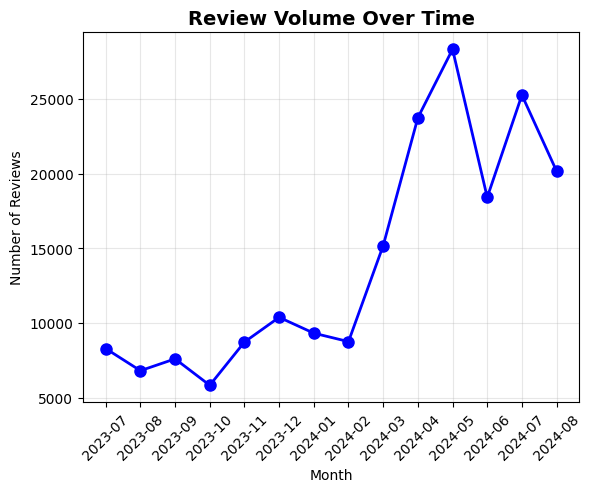

In [ ]:
monthly_counts = df.groupby('Review_Month').size()
plt.plot(monthly_counts.index.astype(str), monthly_counts.values,
         marker='o', linewidth=2, markersize=8, color='blue')

plt.title('Review Volume Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.show()

Sentiment Distribution Over Time

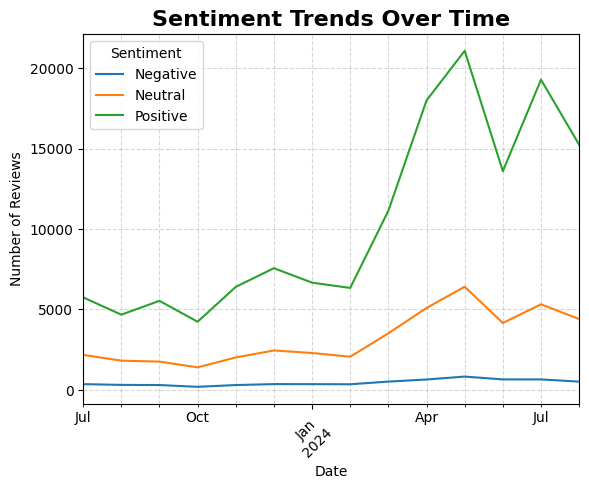

In [ ]:
import matplotlib.pyplot as plt

df['review_date'] = pd.to_datetime(df['review_date'])

sentiment_over_time = df.groupby([df['review_date'].dt.to_period('M'), 'sentiment_category']) \
                        .size().unstack(fill_value=0)

sentiment_over_time.index = sentiment_over_time.index.to_timestamp()
sentiment_over_time.plot()

plt.title('Sentiment Trends Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.legend(title='Sentiment')

plt.show()